# Линейная регрессия в PySpark

## Устанавливаем пакеты

In [60]:
!pip install pyspark setuptools tqdm numpy matplotlib

In [61]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import StructField, IntegerType, StructType, StringType
import matplotlib.pyplot as plt

seed = 666

## Подготовка данных

In [62]:
spark = SparkSession.builder.appName('UsingLinearRegression').getOrCreate()

[Данные](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)
(попробую на небольших)

In [63]:
df = spark.read.option("header",True).csv("data/Student_Performance.csv")
df.summary().show()

+-------+------------------+-----------------+--------------------------+-----------------+--------------------------------+------------------+
|summary|     Hours Studied|  Previous Scores|Extracurricular Activities|      Sleep Hours|Sample Question Papers Practiced| Performance Index|
+-------+------------------+-----------------+--------------------------+-----------------+--------------------------------+------------------+
|  count|             10000|            10000|                     10000|            10000|                           10000|             10000|
|   mean|            4.9929|          69.4457|                      NULL|           6.5306|                          4.5833|           55.2248|
| stddev|2.5893087961856183|17.34315225104711|                      NULL|1.695862976517708|              2.8673477777081446|19.212557799463337|
|    min|                 1|               40|                        No|                4|                               0|            

In [64]:
df.printSchema()

root
 |-- Hours Studied: string (nullable = true)
 |-- Previous Scores: string (nullable = true)
 |-- Extracurricular Activities: string (nullable = true)
 |-- Sleep Hours: string (nullable = true)
 |-- Sample Question Papers Practiced: string (nullable = true)
 |-- Performance Index: string (nullable = true)



In [65]:
coltype_map = { 
    "Hours Studied": IntegerType(), 
    "Previous Scores": IntegerType(), 
    "Sleep Hours": IntegerType(), 
    "Sample Question Papers Practiced": IntegerType(), 
    "Performance Index": IntegerType(), 
} 

df = df.select([col(c).cast(coltype_map[c]) if c in coltype_map else c for c in df.columns])
df.printSchema()

root
 |-- Hours Studied: integer (nullable = true)
 |-- Previous Scores: integer (nullable = true)
 |-- Extracurricular Activities: string (nullable = true)
 |-- Sleep Hours: integer (nullable = true)
 |-- Sample Question Papers Practiced: integer (nullable = true)
 |-- Performance Index: integer (nullable = true)



In [66]:
def get_fraction(_df, column, fraction_part=0.1):
    return _df.sample(fraction=fraction_part, seed=seed).select(column).rdd.flatMap(lambda x: x).collect()

def show_hist_column(_df, column, fraction_part=0.1, bins=10):
    plt.hist(get_fraction(df, column, fraction_part=fraction_part), bins=bins)

    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.show()

#### Hours Studied

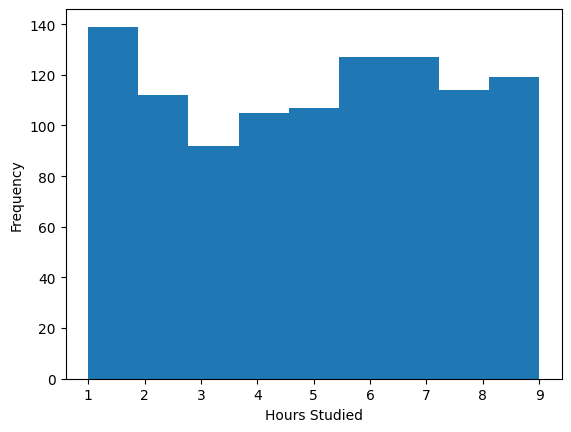

In [67]:
show_hist_column(df, 'Hours Studied', bins=9)

#### Previous Scores

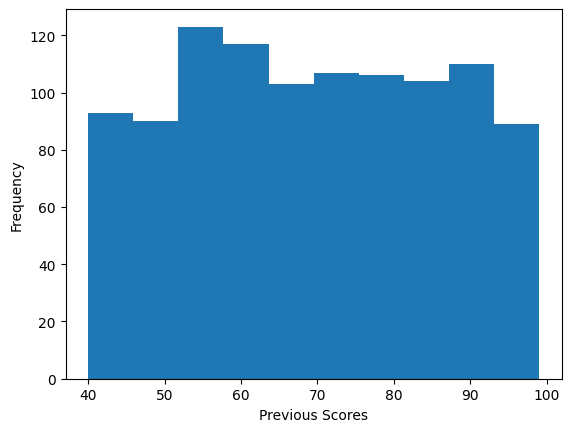

In [68]:
show_hist_column(df, 'Previous Scores')

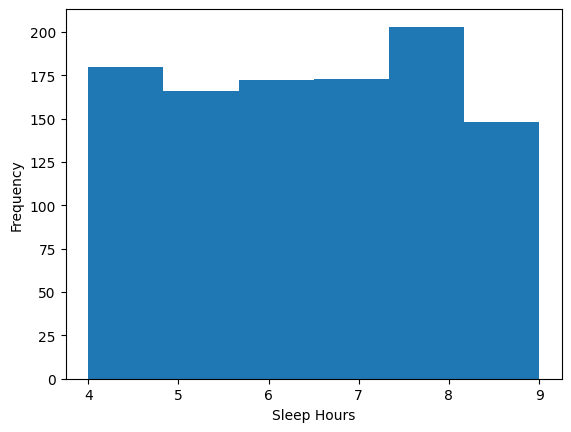

In [69]:
show_hist_column(df, 'Sleep Hours', bins=6)

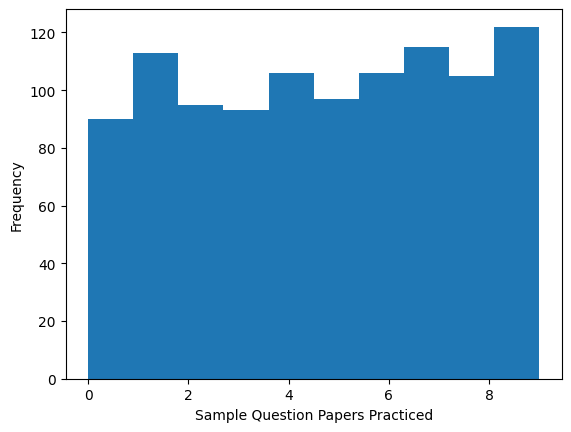

In [70]:
show_hist_column(df, 'Sample Question Papers Practiced')

### Feature engineering 

In [72]:
raise NotImplementedError(':(')

NotImplementedError: :(

### Feature selection 

In [73]:
raise NotImplementedError(':(')

NotImplementedError: :(

raise NotImplementedError(':(')

## Пробуем регрессию

In [71]:
raise NotImplementedError(':(')

NotImplementedError: :(